In [1]:
import emip_toolkit as EMTK
from IPython.display import Image
import correction
import random 
import numpy as np
import PIL
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
img = Image(filename= r'C:\Users\PC\Desktop\NN_with_Transfer_Learning\synthetic_text.png')
# img

In [3]:
image_path =''
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")
aoi.head()

c:\Users\PC\Desktop\NN_with_Transfer_Learning\emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
c:\Users\PC\Desktop\NN_with_Transfer_Learning\emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
c:\Users\PC\Desktop\NN_with_Transfer_Learning\emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
c:\Users\PC\Desktop\NN_with_Transfer_Learning\emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
c:\Users\PC\Desktop\NN_w

,kind,name,x,y,width,height,image
0,sub-line,line 1 part 1,137.5,147,119,44,synthetic_text.png
1,sub-line,line 1 part 2,262.5,147,114,44,synthetic_text.png
2,sub-line,line 1 part 3,382.5,147,65,44,synthetic_text.png
3,sub-line,line 1 part 4,453.5,147,57,44,synthetic_text.png
4,sub-line,line 1 part 5,514.5,147,72,44,synthetic_text.png


In [4]:
file_path = ''
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()

,kind,name,x,y,width,height,image,token
0,sub-line,line 1 part 1,137.5,147,119,44,synthetic_text.png,Margie
1,sub-line,line 1 part 2,262.5,147,114,44,synthetic_text.png,moved
2,sub-line,line 1 part 3,382.5,147,65,44,synthetic_text.png,into
3,sub-line,line 1 part 4,453.5,147,57,44,synthetic_text.png,her
4,sub-line,line 1 part 5,514.5,147,72,44,synthetic_text.png,new


In [5]:
line_ys = correction.find_lines_Y(aois_with_tokens)

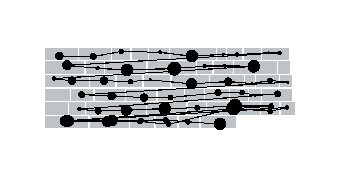

In [6]:
# generate generic visualizations of the trial
synth_fixations = correction.generate_fixations_lr_skip_regression(aois_with_tokens)
im = correction.fix_to_img_general('synthetic_text.png', synth_fixations, aois_with_tokens)
plt.axis('off')
plt.imshow(np.asarray(im), interpolation='nearest')
plt.show()

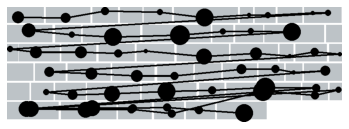

In [7]:
# crop the white space
from PIL import Image, ImageChops

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

# im = Image.open("bord3.jpg")
im_trim = trim(im)
plt.axis('off')
plt.imshow(im_trim)
plt.show()

In [8]:
input_shape = np.asarray(im_trim).shape

x = input_shape[0]
y = input_shape[1]
n = 20 # scale of increments


input_x = x//2
input_y = y//2
num_train = 5*11*n

x_train = np.zeros((num_train, input_x, input_y, 3), dtype=np.uint8)
y_train = np.zeros(num_train, dtype=int)

error_types = [0, 1, 2, 3, 4]

In [9]:
# overarching tool-box function that converts a set of fixations to an image input ready to be fed into the neural network

def prep_image(img_path, fixations, aois, input_x, input_y):
    im = correction.fix_to_img_general(img_path, fixations, aois)
    im_trim = trim(im)
    im_small = im_trim.resize((input_y, input_x))
    im_small_array = np.asarray(im_small)

    return im_small_array
    

In [10]:
def make_error_trial (error_type, factor):
    synth_fixations = correction.generate_fixations_lr_skip_regression(aois_with_tokens)
        
    if error_type == 0: # noise
        error_trial = correction.error_noise(factor/10.0, random.randint(0, 50), factor/10.0, synth_fixations) 
    elif error_type == 1: # shift
        line_ys = np.array(synth_fixations)[:, 1]
        error_trial = correction.error_shift(factor/10.0, line_ys, synth_fixations) 

    elif error_type == 2: # droop
        error_trial = correction.error_droop(factor, synth_fixations)  
    
    elif error_type == 3: # offset 
        error_trial = correction.error_offset(factor*2.0, factor*2.0, synth_fixations)
    elif error_type == 4: # no error
        error_trial = synth_fixations  

    else: # wrong entry
        print("Error: wrong entry; there is no error category")
        return
    return error_trial

In [11]:
prev = 0

for i in range(len(error_types)): 
    for j in range(0, 11): 
        for index in range(n):
          w = i*11*n + j*n + index
          
          # double check the index in x_train is correct
          if w < prev:
            print(i, j, index, w, prev)
            exit()
          else:
            prev = w
            
          error_trial = make_error_trial(error_types[i], j+index*1/n)
          if j == 0 and index == 0:
           y_train[w] = 4
          else:
           y_train[w] = error_types[i]

          preped_img = prep_image('synthetic_text.png', error_trial, aois_with_tokens, input_x, input_y)

          x_train[w] = preped_img

          # plt.imshow(x_train[index])


np.save("data/x_train_mix_ayn.npy", x_train)
np.save("data/y_train_mix_ayn.npy",y_train)

3


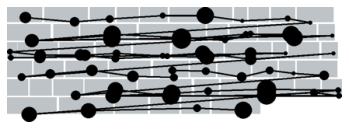

In [18]:
# example of the input of a trial with shift error
a = 800
plt.imshow(x_train[a])
plt.axis("off")
print(y_train[a])

In [19]:
n_test = 500

x_test = np.zeros((n_test, input_x, input_y, 3), dtype=np.uint8)
y_test = np.zeros(n_test, dtype=int)

In [21]:
for i in range(n_test):
    error = random.choice(error_types)
    factor = random.randint(0, 11)

    error_trial = make_error_trial(error, factor)
    
    if factor == 0:
        y_test[i] = 4
    else:
        y_test[i] = error

    preped_img = prep_image('synthetic_text.png', error_trial, aois_with_tokens, input_x, input_y)
    x_test[i] = preped_img

np.save("data/x_test_mix_ayn.npy", x_test)
np.save("data/y_test_mix_ayn.npy", y_test)

3


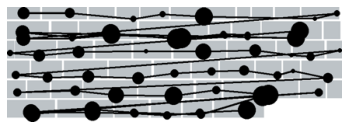

In [25]:
t = 300
plt.imshow(x_test[t])
plt.axis("off")
print(y_test[t])

3


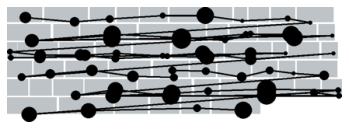

In [26]:
# example of the input of a trial with shift error
a = 800
plt.imshow(x_train[a])
plt.axis("off")
print(y_train[a])